# Gradient Boosting (Literature-Based) Model – House Price Prediction

This notebook re-implements **Gradient Boosting Regressor** for the Kaggle **House Prices – Advanced Regression Techniques** dataset, following the methodology described in the paper:  **"Housing price prediction with gradient boostted trees under different loss functions"** by Anders Hjort, Johan Pensar, Ida Scheel & Dag Einar Sommervoll (2022). 

The approach includes the following steps:
- Load and preprocess the Kaggle House Prices – Advanced Regression Techniques dataset.
- Apply a log transformation to the target variable, `SalePrice`, to improve model performance.
- Experiment with several built-in loss functions avaliable in `GradientBoostingRegressor`:
  - `squared_error`
  - `absolute_error`
  - `huber`
- Select the configuration that achieves the lowest validation Mean Squared Error (MSE) through cross-validation.

Using the Kaggle **"House Prices – Advanced Regression Techniques"** dataset, the goal is to reproduce the papers idea of evaluating how different loss functions impact Gradient Boosting performance on housing data. Additonally, the notebooks computes the **Mean Squared Error (MSE)**, **Root Mean Squared Error (RMSE)**, **Mean Absolute Error (MAE)**, and **log-space metrics**, which are then used to generate the residual plot, error histogram, and actual vs. predicted plots.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# Load dataset (adjust path if needed)
df = pd.read_csv("train.csv")
print("Shape:", df.shape)
df.head()

Shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# Target and features
y_raw = df["SalePrice"].copy()
y = np.log1p(y_raw)  # log1p transform for stability
X = df.drop(columns=["SalePrice"])

# Feature types
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=(["object"])).columns.tolist()

print("Numeric features:", len(num_features))
print("Categorical features:", len(cat_features))

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)

# Train/validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, X_valid.shape


Numeric features: 37
Categorical features: 43


((1168, 80), (292, 80))

In [4]:
def eval_metrics(y_true_log, y_pred_log):
    # Return MSE, MAE, RMSE in original SalePrice scale and R^2 in log-space.
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_log, y_pred_log)
    return mse, mae, rmse, r2


def plot_residuals_and_errors(name, y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    residuals = y_true - y_pred

    plt.figure(figsize=(12, 4))

    # Residual plot
    plt.subplot(1, 2, 1)
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel("Predicted SalePrice")
    plt.ylabel("Residual (True - Pred)")
    plt.title(f"{name} – Residual Plot")

    # Error histogram
    plt.subplot(1, 2, 2)
    sns.histplot(residuals, bins=40, kde=True, stat="density", alpha=0.6)
    plt.xlabel("Residual")
    plt.ylabel("Density")
    plt.title(f"{name} – Residual Histogram")

    plt.tight_layout()
    plt.show()


def plot_actual_vs_pred(name, y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)

    plt.figure(figsize=(10, 5))
    plt.scatter(y_true, y_pred, alpha=0.5)
    max_val = max(y_true.max(), y_pred.max())
    min_val = min(y_true.min(), y_pred.min())
    plt.plot([min_val, max_val], [min_val, max_val], "r--")
    plt.xlabel("Actual SalePrice")
    plt.ylabel("Predicted SalePrice")
    plt.title(f"{name} – Actual vs Predicted")
    plt.tight_layout()
    plt.show()


In [5]:
# Gradient Boosting Regressor with GridSearchCV
gbr = GradientBoostingRegressor(random_state=42)

gbr_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", gbr),
])

gbr_params = {
    "model__loss": ["squared_error", "absolute_error", "huber"],
    "model__n_estimators": [200, 300, 500],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__max_depth": [2, 3, 4],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2],
}

gbr_search = GridSearchCV(
    gbr_pipe,
    param_grid=gbr_params,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1,
)
gbr_search.fit(X_train, y_train)
print("Best Gradient Boosting Parameters:", gbr_search.best_params_)

y_valid_pred_gbr = gbr_search.predict(X_valid)
mse_g, mae_g, rmse_g, r2_g = eval_metrics(y_valid, y_valid_pred_gbr)
print("\n=== Gradient Boosting (Literature-Model) ===")
print(f"MSE  (original $): {mse_g:,.2f}")
print(f"MAE  (original $): {mae_g:,.2f}")
print(f"RMSE (original $): {rmse_g:,.2f}")
print(f"R^2  (log-space) : {r2_g:.4f}")


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Gradient Boosting Parameters: {'model__learning_rate': 0.1, 'model__loss': 'absolute_error', 'model__max_depth': 3, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 500}

=== Gradient Boosting (Literature-Model) ===
MSE  (original $): 807,882,013.57
MAE  (original $): 16,000.38
RMSE (original $): 28,423.27
R^2  (log-space) : 0.9040


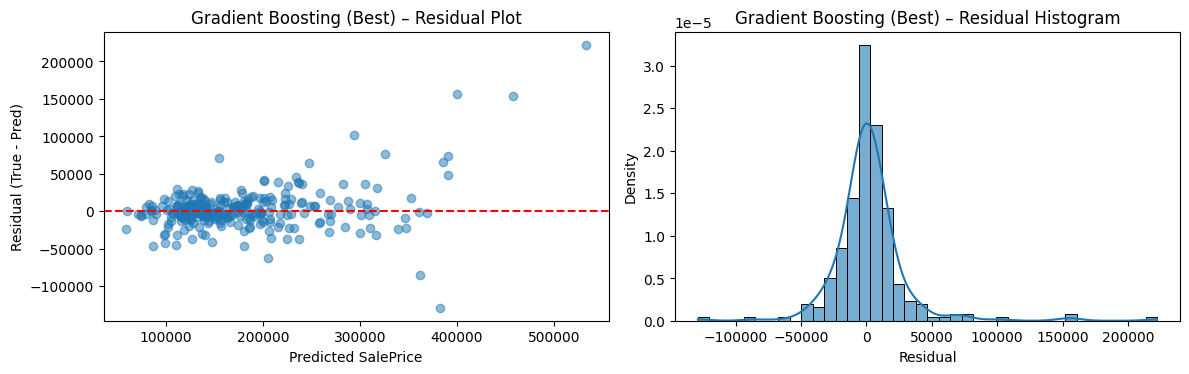

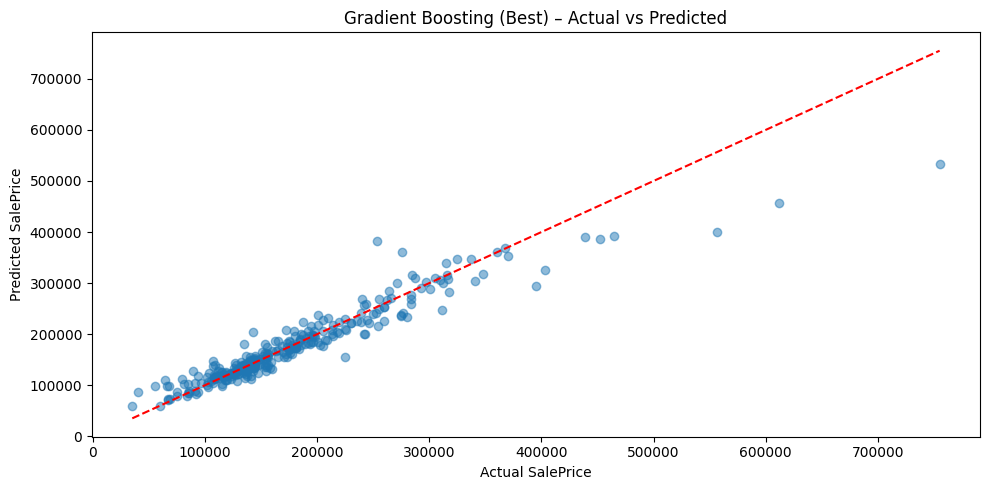

In [6]:
# Residuals and error histograms for Gradient Boosting
plot_residuals_and_errors("Gradient Boosting (Best)", y_valid, y_valid_pred_gbr)

# Actual vs predicted
plot_actual_vs_pred("Gradient Boosting (Best)", y_valid, y_valid_pred_gbr)
